# Kickstarter Projects
This is a Notebook to work the kickstarter_projects kaggle dataset. We're about to see how bla bla...

database link: https://www.kaggle.com/datasets/kemical/kickstarter-projects

atributs inicials : ID, name, category, main_category, currency, deadline, goal, launched, pledged, state, backers, country, usd pledged

In [1]:
# Imports
import numpy as np
import pandas as pd
import datetime as dt
import time
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
from sklearn import svm,datasets,tree,neighbors,metrics

import category_encoders as ce
import matplotlib.pyplot as plt

Usaremos el segundo dataset puesto que ambos tienen algunos atributos diferentes, ambos tienen instancias en común costosas de filtrar, ambos tienen más de 300000 instancias (información más que suficiente) y el segundo tiene los atributos monetarios ya convertidos a USD

In [2]:
#Load datasets
#df1 = pd.read_csv('./datasets/ks-projects-201612.csv', encoding = 'utf-8', encoding_errors = 'replace')
#df2 = pd.read_csv('./datasets/ks-projects-201801.csv', encoding = 'cp1252', encoding_errors = 'replace')

df = pd.read_csv('./datasets/ks-projects-201801.csv', encoding = 'cp1252', encoding_errors = 'replace')

In [3]:
# Podemos ver atributos que no nos dicen nada como ID, name, usd_pledged (usd_pledged_real millor)
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
df = df.drop(columns=['ID', 'name', 'usd pledged', 'pledged', 'goal'])
print(df.isnull().sum(axis = 0))
print((df == '?').sum(axis=0))

category            0
main_category       0
currency            0
deadline            0
launched            0
state               0
backers             0
country             0
usd_pledged_real    0
usd_goal_real       0
dtype: int64
category            0
main_category       0
currency            0
deadline            0
launched            0
state               0
backers             0
country             0
usd_pledged_real    0
usd_goal_real       0
dtype: int64


Hemos tenido mucha suerte al no tener NaNs

In [5]:
# definimos nuevos atributos
df['elapsed_days'] = (pd.to_datetime(df['deadline'])-pd.to_datetime(df['launched'])).dt.total_seconds()/(3600*24)
#df['deadline'] = (pd.to_datetime(df['deadline']) - dt.datetime(2009,1,1)).dt.total_seconds()
#df['launched'] = (pd.to_datetime(df['launched']) - dt.datetime(2009,1,1)).dt.total_seconds()
df = df.drop(columns=['launched', 'deadline'])

df['pledged/backer'] = df['usd_pledged_real']/df['backers']
df['pledged/backer'].fillna(value = 0, inplace=True)
a = np.max(df['pledged/backer'])
df.loc[df["pledged/backer"] == a, "pledged/backer"] = 0

col_list = list(df.columns)
x, y = col_list.index(df.columns[-1]), col_list.index('state')
col_list[y], col_list[x] = col_list[x], col_list[y]
df = df[col_list]

col_list = list(df.columns)
x, y = col_list.index('pledged/backer'), col_list.index('country')
col_list[y], col_list[x] = col_list[x], col_list[y]
df = df[col_list]

In [6]:
aux = df['state'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
#should we drop live all except failed and successful?
print((auxn[1] + auxn[3])/auxn.sum())

['canceled' 'failed' 'live' 'successful' 'suspended' 'undefined']
[ 38779 197719   2799 133956   1846   3562]
0.8759153966212523


In [7]:
# nos quedamos solo con los registros fallidos o logrados (~88%)
df = df[np.logical_or(df['state'] == 'failed',df['state'] == 'successful')]
df.loc[df["state"] == "failed", "state"] = 0
df.loc[df["state"] == "successful", "state"] = 1

Veamos cómo son nuestros atributos categóricos

In [8]:
#23 paises distintos
aux = df['country'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
print(aux.shape)

['AT' 'AU' 'BE' 'CA' 'CH' 'DE' 'DK' 'ES' 'FR' 'GB' 'HK' 'IE' 'IT' 'JP'
 'LU' 'MX' 'N,0"' 'NL' 'NO' 'NZ' 'SE' 'SG' 'US']
[   485   6616    523  12370    652   3436    926   1873   2520  29454
    477    683   2369     23     57   1411    210   2411    582   1274
   1509    454 261360]
(23,)


In [9]:
#15 categorias principales
aux = df['main_category'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
print(aux.shape)

['Art' 'Comics' 'Crafts' 'Dance' 'Design' 'Fashion' 'Film & Video' 'Food'
 'Games' 'Journalism' 'Music' 'Photography' 'Publishing' 'Technology'
 'Theater']
[25641  9878  7818  3573 25364 19775 56527 22054 28521  4149 45949  9689
 35445 27050 10242]
(15,)


In [10]:
#159 categorias
aux = df['category'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
print(aux.shape)

['3D Printing' 'Academic' 'Accessories' 'Action' 'Animals' 'Animation'
 'Anthologies' 'Apparel' 'Apps' 'Architecture' 'Art' 'Art Books' 'Audio'
 'Bacon' 'Blues' 'Calendars' 'Camera Equipment' 'Candles' 'Ceramics'
 "Children's Books" 'Childrenswear' 'Chiptune' 'Civic Design'
 'Classical Music' 'Comedy' 'Comic Books' 'Comics' 'Community Gardens'
 'Conceptual Art' 'Cookbooks' 'Country & Folk' 'Couture' 'Crafts'
 'Crochet' 'DIY' 'DIY Electronics' 'Dance' 'Design' 'Digital Art'
 'Documentary' 'Drama' 'Drinks' 'Electronic Music' 'Embroidery' 'Events'
 'Experimental' 'Fabrication Tools' 'Faith' 'Family' 'Fantasy'
 "Farmer's Markets" 'Farms' 'Fashion' 'Festivals' 'Fiction' 'Film & Video'
 'Fine Art' 'Flight' 'Food' 'Food Trucks' 'Footwear' 'Gadgets' 'Games'
 'Gaming Hardware' 'Glass' 'Graphic Design' 'Graphic Novels' 'Hardware'
 'Hip-Hop' 'Horror' 'Illustration' 'Immersive' 'Indie Rock'
 'Installations' 'Interactive Design' 'Jazz' 'Jewelry' 'Journalism' 'Kids'
 'Knitting' 'Latin' 'Letterpress'

In [11]:
attributes = df.columns
for i in range(len(attributes)):
    print(i, attributes[i])

0 category
1 main_category
2 currency
3 country
4 backers
5 pledged/backer
6 usd_pledged_real
7 usd_goal_real
8 elapsed_days
9 state


In [12]:
df.describe()

,backers,pledged/backer,usd_pledged_real,usd_goal_real,elapsed_days
count,331675.000000,331675.000000,3.316750e+05,3.316750e+05,331675.000000
mean,116.381581,66.087346,9.943461e+03,4.151000e+04,33.389378
std,965.427268,131.610145,9.673293e+04,1.108930e+06,12.723385
min,0.000000,0.000000,0.000000e+00,1.000000e-02,0.005058
25%,2.000000,16.673375,5.000000e+01,2.000000e+03,29.088929
50%,15.000000,42.304593,7.880000e+02,5.000000e+03,29.656759
75%,63.000000,77.533542,4.608000e+03,1.500000e+04,35.705966
max,219382.000000,10000.000000,2.033899e+07,1.663614e+08,91.962650


In [13]:
# outliers
df1 = df[df['backers'] <= 200]
df1 = df1[df1['usd_goal_real'] <= 10000]
df1 = df1[df1['usd_goal_real'] >= 10]
#df1 = df1[df1['usd_pledged_real'] <= 100000]
df1 = df1[df1['pledged/backer'] <= 300]
#df1 = df1[df1['pledged/backer'] > 0] #uncomment to see gamma distribution
df = df1

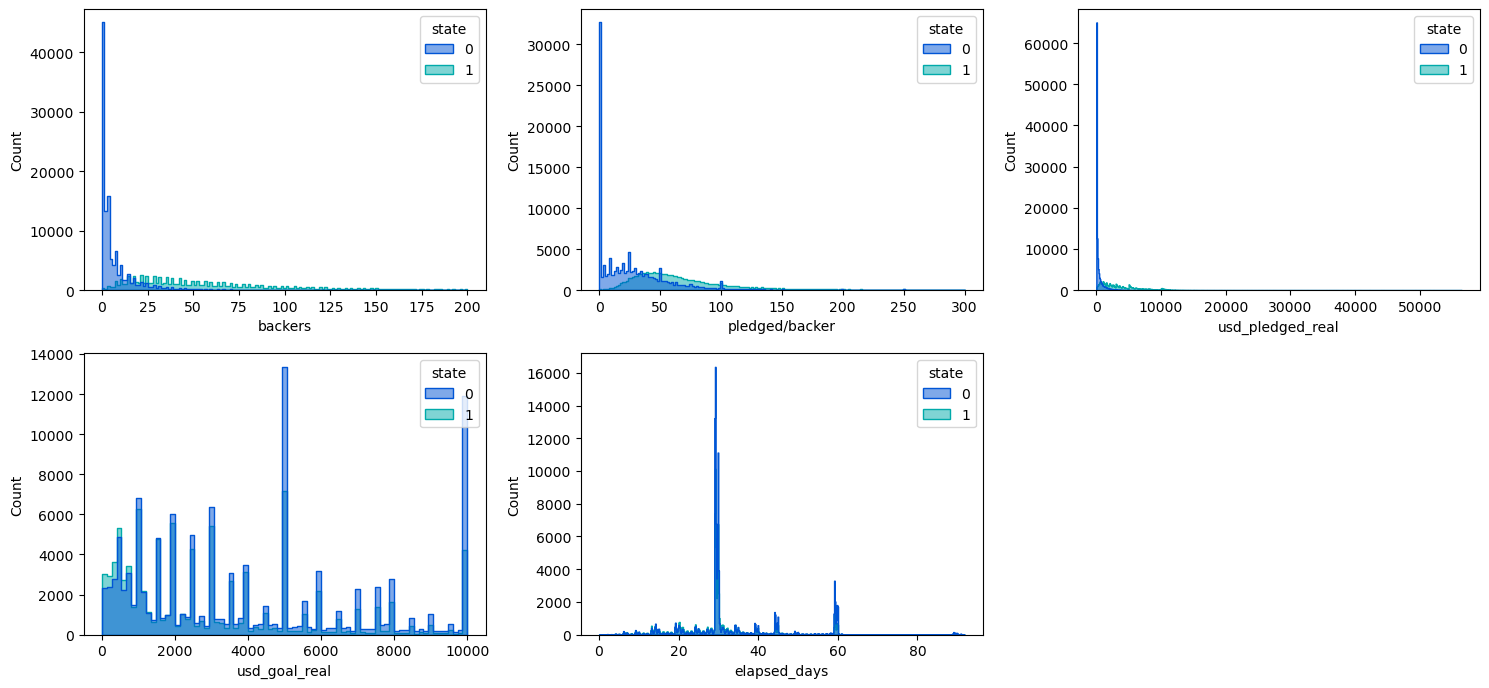

In [14]:
# distribució dels atributs segons els dos valors de l'state
plt.figure(figsize = (15,10), tight_layout = True)

for i, feature in enumerate(df.columns[4:9]):
    plt.subplot(3,3,i+1)
    sns.histplot(data = df1, x =feature, palette='winter', hue = 'state',alpha = 0.5, element="step" )

In [15]:
df.dtypes

category             object
main_category        object
currency             object
country              object
backers               int64
pledged/backer      float64
usd_pledged_real    float64
usd_goal_real       float64
elapsed_days        float64
state                object
dtype: object

<AxesSubplot:>

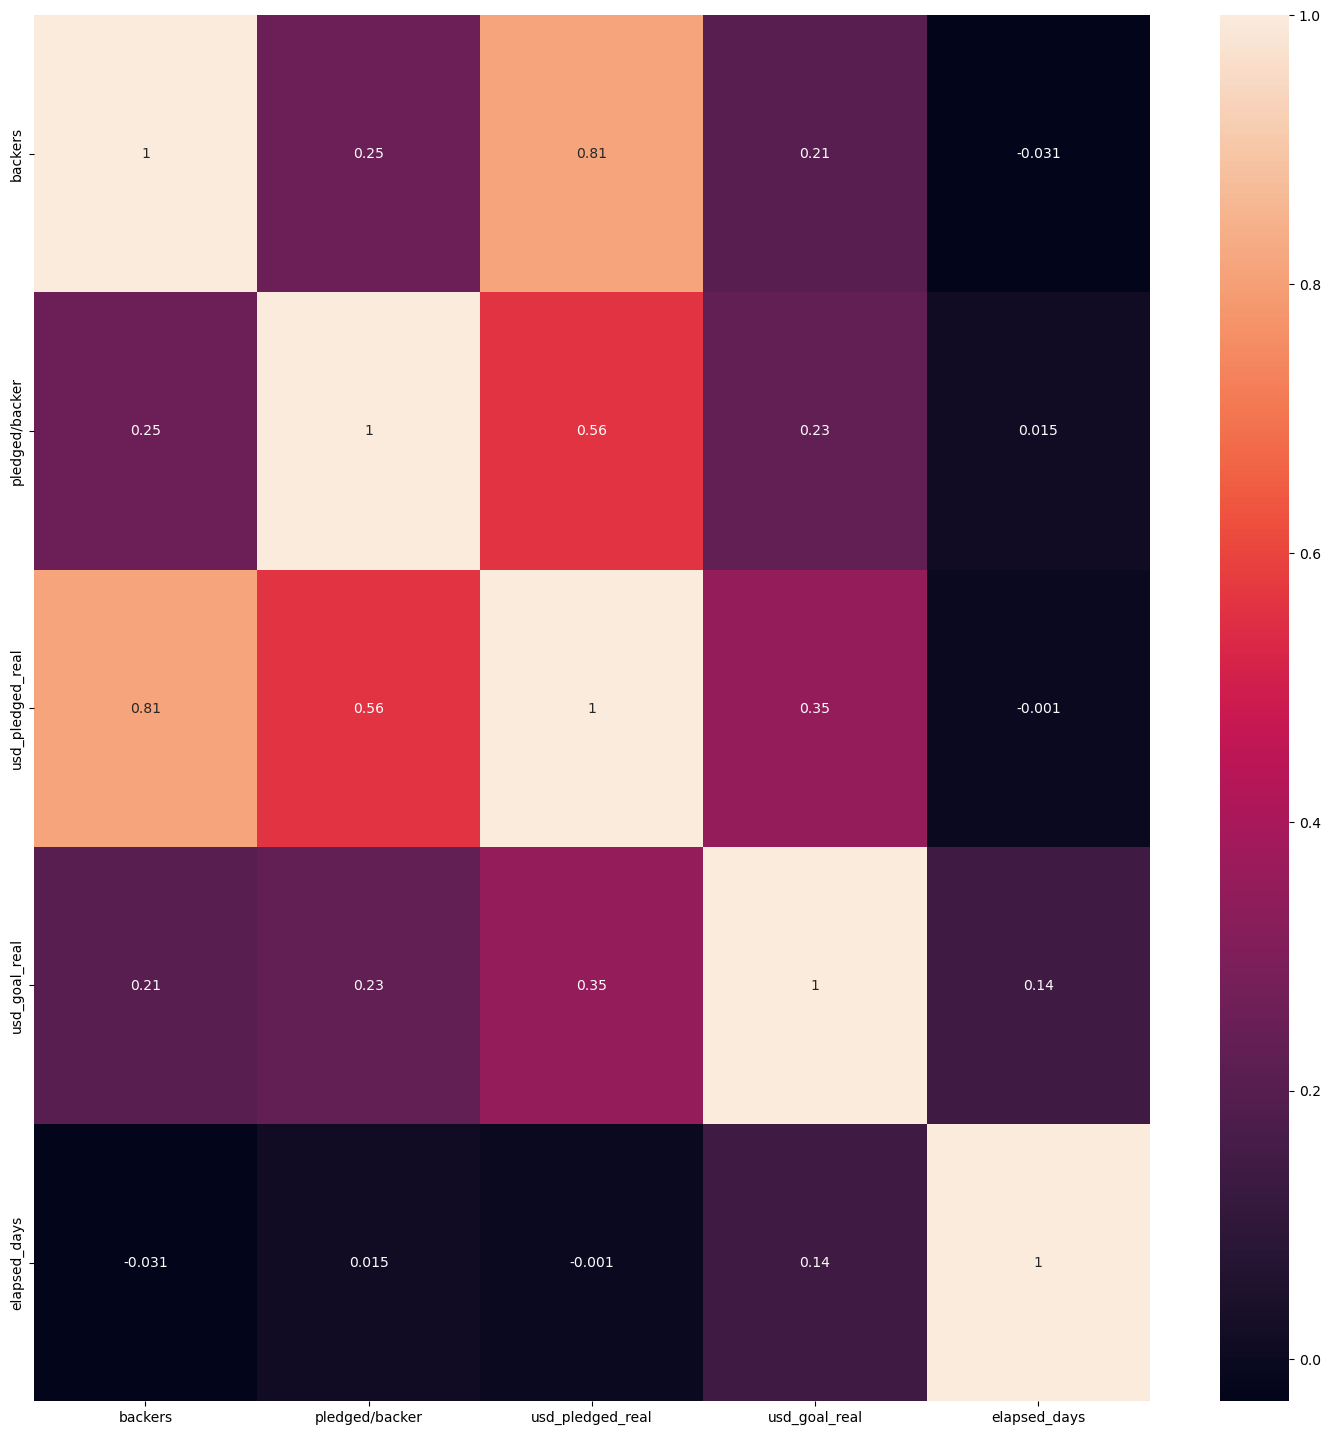

In [16]:
fig, ax = plt.subplots(figsize = (18,18))
sns.heatmap(df.corr(), ax = ax, annot = True)

In [17]:
ce_OHE = ce.OneHotEncoder(cols=['currency','category'])

data1 = ce_OHE.fit_transform(df)
#data1

In [18]:
ce_be = ce.BinaryEncoder(cols=df.columns[0:4]);

# transform the data
data_binary = ce_be.fit_transform(df);
dff = data_binary
dff

,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,main_category_0,main_category_1,...,country_1,country_2,country_3,country_4,backers,pledged/backer,usd_pledged_real,usd_goal_real,elapsed_days,state
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0.000000,0.00,1533.95,58.491343,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,1.000000,1.00,5000.00,29.858206,0
6,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,16,75.312500,1205.00,1000.00,19.228657,1
10,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,0,0.000000,0.00,2406.39,29.236377,0
12,0,0,0,0,0,1,0,1,0,1,...,0,0,1,0,0,0.000000,0.00,5000.00,29.283449,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378652,0,0,0,1,0,1,0,0,1,0,...,0,1,0,1,36,79.884167,2875.83,2675.19,29.103785,1
378653,0,0,0,1,0,1,0,0,1,0,...,0,0,1,0,1,25.000000,25.00,1700.00,29.811690,0
378654,0,1,1,0,1,1,0,0,0,0,...,0,0,1,0,4,38.500000,154.00,6500.00,29.077523,0
378657,0,0,0,1,0,1,0,1,1,0,...,0,0,1,0,5,31.000000,155.00,1500.00,26.850532,0


In [19]:
mm = MinMaxScaler()
mm_data = mm.fit_transform(dff)
mm_data

array([[0.        , 0.        , 0.        , ..., 0.15254755, 0.63684585,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.4994995 , 0.32490281,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.0990991 , 0.20909944,
        1.        ],
       ...,
       [0.        , 1.        , 1.        , ..., 0.64964965, 0.31639768,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.14914915, 0.29213578,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.1991992 , 0.30051431,
        0.        ]])

# Train/Test

In [20]:
X = mm_data[:, :-1]
y = mm_data[:,-1].astype(int)
x_t, x_v, y_t, y_v = train_test_split(X, y, test_size = 0.3, random_state = 42)

C:\Users\javie\anaconda3\envs\spyder-env\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNN amb k 1
0.9416409138814955


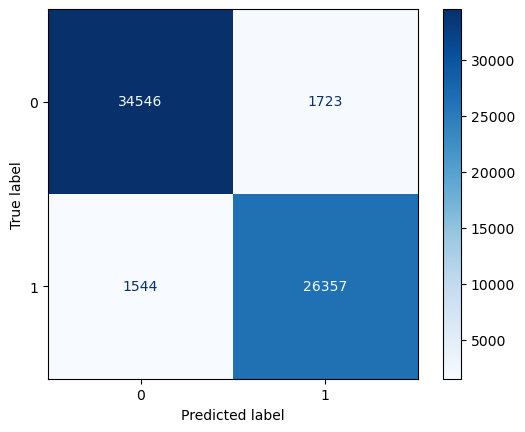

C:\Users\javie\anaconda3\envs\spyder-env\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNN amb k 2
0.9277791196744765


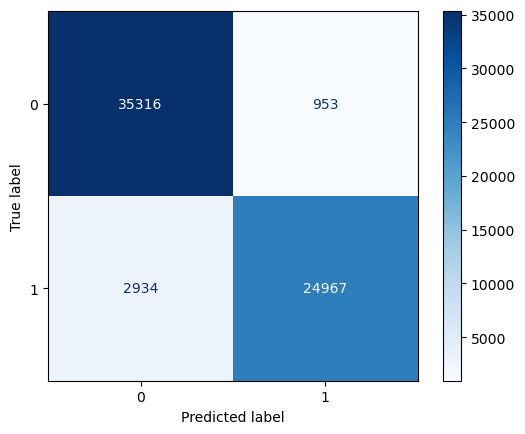

C:\Users\javie\anaconda3\envs\spyder-env\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNN amb k 3
0.9390041567801901


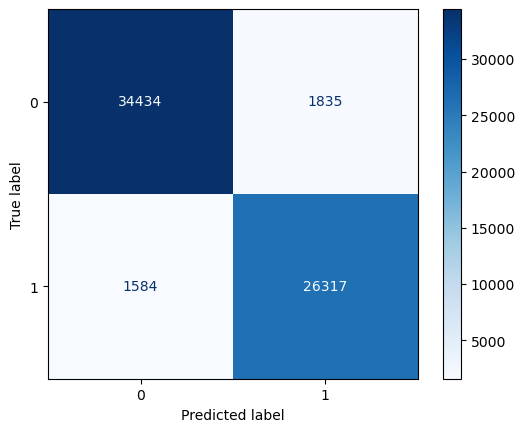

C:\Users\javie\anaconda3\envs\spyder-env\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNN amb k 4
0.9332967535436671


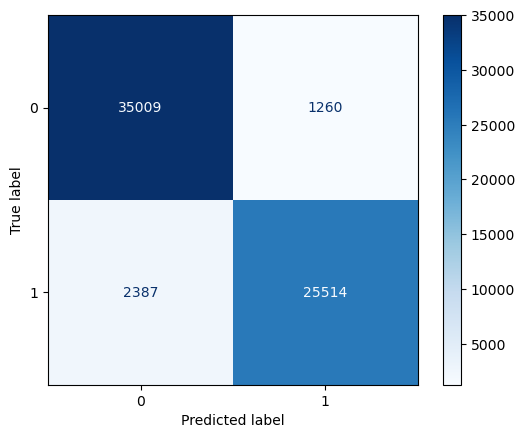

In [21]:
from sklearn.neighbors import KNeighborsClassifier

for i in range(5)[1:]:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_t, y_t)
    preds = knn.predict(x_v)
    print('KNN amb k ' + str(i))
    #mirar la f1 score
    score = f1_score(y_v, preds)
    print(score)
    #confusion matrix
    cm = metrics.confusion_matrix(y_v, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp = disp.plot(cmap=plt.cm.Blues)
    plt.show()


f1_score = 0.9683588255194886


C:\Users\javie\anaconda3\envs\spyder-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


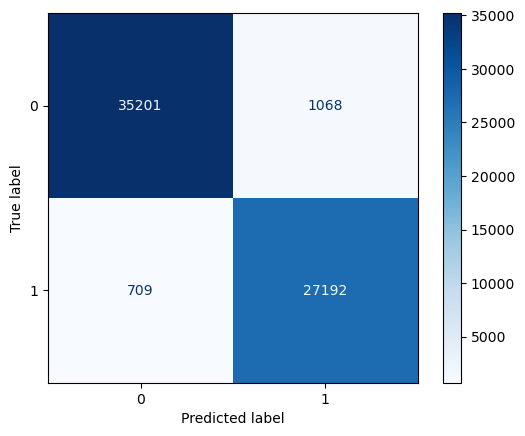

In [22]:
from sklearn.linear_model import LogisticRegression

LogisticRegression = LogisticRegression(C=0.5)
LogisticRegression.fit(x_t, y_t)
preds = LogisticRegression.predict(x_v)

#calcular la f1 score
score = f1_score(y_v, preds)
print("f1_score = " + str(score))

#confusion matrix
cm = metrics.confusion_matrix(y_v, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

In [23]:
from sklearn.svm import SVC
'''
C = 9.0
gamma = 0.2
degree = 8.0
kernel_options = ['linear', 'poly', 'sigmoid', 'rbf']
for ker in kernel_options:
    if ker == 'poly':
        svclassifier = svm.SVC(kernel=ker, degree=degree, gamma='auto', C=C)
    elif ker == 'linear':     
        svclassifier = svm.SVC(kernel=ker, C=0.01)
    elif ker == 'rbf':
        svclassifier = svm.SVC(kernel='rbf', gamma=gamma, C=C)
    elif ker == 'sigmoid':
        svclassifier = svm.SVC(kernel='sigmoid', gamma=gamma, C=C)
        
    svclassifier.fit(x_t, y_t)
    svcPreds = svclassifier.predict(x_v)
    print('SVM amb kernel ' + ker)
    #mirar la f1 score
    score = f1_score(y_v, svcPreds)
    print(score)
    #confusion matrix
    cm = metrics.confusion_matrix(y_v, svcPreds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp = disp.plot(cmap=plt.cm.Blues)
    plt.show()
'''

"\nC = 9.0\ngamma = 0.2\ndegree = 8.0\nkernel_options = ['linear', 'poly', 'sigmoid', 'rbf']\nfor ker in kernel_options:\n    if ker == 'poly':\n        svclassifier = svm.SVC(kernel=ker, degree=degree, gamma='auto', C=C)\n    elif ker == 'linear':     \n        svclassifier = svm.SVC(kernel=ker, C=0.01)\n    elif ker == 'rbf':\n        svclassifier = svm.SVC(kernel='rbf', gamma=gamma, C=C)\n    elif ker == 'sigmoid':\n        svclassifier = svm.SVC(kernel='sigmoid', gamma=gamma, C=C)\n        \n    svclassifier.fit(x_t, y_t)\n    svcPreds = svclassifier.predict(x_v)\n    print('SVM amb kernel ' + ker)\n    #mirar la f1 score\n    score = f1_score(y_v, svcPreds)\n    print(score)\n    #confusion matrix\n    cm = metrics.confusion_matrix(y_v, svcPreds)\n    disp = ConfusionMatrixDisplay(confusion_matrix=cm)\n    disp = disp.plot(cmap=plt.cm.Blues)\n    plt.show()\n"